In [40]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 读取数据集

In [4]:
train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv')
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [9]:
# 拼接出特征矩阵
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

## 数据预处理

In [10]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # 特征值是数值类型的所有列
# 对所有数值类型的列进行特征缩放
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化数据后，将缺失值替换成0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
# 再使用独热编码的方式处理离散值,“Dummy_na=True”将“na”（缺失值）也视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape # 特征总数量从79变成了331

(2919, 331)

In [11]:
# 从all_features提取出训练集、训练集标签、以及测试集
n_train = train_data.shape[0] # 训练样例数
train_features = torch.tensor(all_features[:n_train].values, 
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, 
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), 
                            dtype=torch.float32)

## 定义MLP模型及损失函数

In [69]:
loss = nn.MSELoss() 
in_features = train_features.shape[1]
num_hidden, dropout = 128, 0.1
# 返回一个全新的MLP模型
def get_net():
    net = nn.Sequential(nn.Linear(in_features, num_hidden), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(num_hidden, 1))
    return net

In [21]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf')) 
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [22]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    # 一次epoch后的训练损失、测试损失
    train_ls, test_ls = [], []
    
    # 将训练数据加载成迭代器
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    
    # 这里使用的是Adam优化算法,Adam优化器的主要吸引力在于它对初始学习率不那么敏感。
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay = weight_decay)
    
    # 训练
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        # 训练完一个epoch后，记录训练中的log_rmse损失
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            
    return train_ls, test_ls

## 使用K折交叉验证来选择超参数

In [23]:
# 将竞赛的训练集分为K折，其中第i折作为验证集,返回：训练集、训练标签、验证集、验证标签
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k # 一折包含的样本数
    X_train, y_train = None, None
    for j in range(k):
        # 选中当前折
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            # 将当前折作为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            # 当前折是训练集中的第一折
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [24]:
# 使用K折交叉验证，训练K次后，返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    # 训练K次的损失总和
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # 获取本次训练的数据集（训练集、验证集）
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        # 训练完成后，获取在此数据集上每个epoch产生的训练损失、验证损失
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        # 累加最后一个epoch的损失
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        # 画图相关
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.115695, 验证log rmse0.157644
折2，训练log rmse0.106102, 验证log rmse0.164490
折3，训练log rmse0.110582, 验证log rmse0.158338
折4，训练log rmse0.117935, 验证log rmse0.151609
折5，训练log rmse0.102036, 验证log rmse0.162195
5-折验证: 平均训练log rmse: 0.110470, 平均验证log rmse: 0.158855


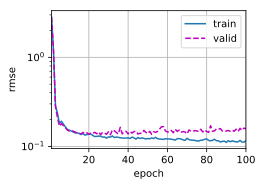

In [70]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 生成csv上传到Kaggle

In [71]:
# 我们知道应该选择什么样的超参数后（这是前提，也就是为什么我们要进行K折交叉验证的原因）， 我们不妨使用所有数据对其进行训练
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    # 在本次竞赛的整个训练集上进行训练
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    
    # 将训练好的模型应用于测试集，得出所有预测值
    preds = net(test_features).detach().numpy()
    
    # 将预测值重新格式化以导出到Kaggle
    # 新增SalePrice列存放模型预测结果
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    # 将测试集的样本Id与预测结果SalePrice拼接起来作为我们需要提交的内容
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    # 当前目录下生成一个csv文件
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.107591


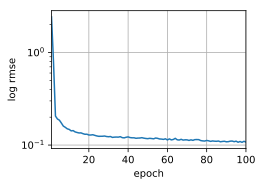

In [72]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)